# Sky rendering 

The sky color are estimated using an implementation of Preetham on a grid of triangles.
Color calculation needs : 
    - turbidity of the sky
    - Sun position (azimuth and inclination from the zenith), calulated via PyEphem
    - coordinates of the points where the sky clor is computed


The initial point grid is regularely spaced in screen coordinated and then convecrted in sky coordinates.


In [1]:
import ephem
from datetime import datetime
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm, colors
from mpl_toolkits.mplot3d import Axes3D

In [2]:
%matplotlib notebook

In [4]:
from levelscape.classes import PolygonObject
from levelscape.sky.sky_models import sky_color, haversine_np_grid, colormodels, simulate_color, celestial_bodies_position, create_sky_grid, gnomomic_projection, haversine_np

Loading chipmunk for Linux (64bit) [/home/pascal/Project/levelscape/venv/lib/python3.6/site-packages/pymunk/libchipmunk.so]


In [5]:
lon, lat = '5.747832', '45.202847'# La Tronche
d_now =  datetime.utcnow()
theta,phi, X, Y = celestial_bodies_position(date=d_now,lon=lon,lat=lat,
                          height=1, width=1,
                          theta_min=0, theta_max=np.pi/2, phi_min=-np.pi,  phi_max=np.pi)


In [6]:
np.arctan2

<ufunc 'arctan2'>

In [286]:
def gnomonic_projection(theta, phi, theta_0, phi_0):
    """
    from http://mathworld.wolfram.com/GnomonicProjection.html
    :param theta: 
    :param phi: lon
    :param theta_0:
    :param phi_0:
    :return:
    """
    #c = haversine_np(phi, theta, phi_0, theta_0)
    #cos_c = np.cos(c)
    
    cos_theta = np.cos(theta)
    sin_theta = np.sin(theta)

    sin_phi = np.sin(phi - phi_0)
    cos_phi = np.cos(phi - phi_0)

    cos_c = np.sin(theta_0)*sin_theta+np.cos(theta_0)*cos_theta*cos_phi
    
    x = cos_theta * sin_phi / cos_c
    y = (np.cos(theta_0) * sin_theta - np.sin(theta_0) * cos_theta * cos_phi) / cos_c

    return x, y

def inv_gnomonic_projection(x, y, theta_0, phi_0):
    rho = np.sqrt(x ** 2 + y ** 2)
    c = np.arctan(rho)
    sin_c = np.sin(c)
    cos_c = np.cos(c)

    theta = np.arcsin(cos_c * np.sin(theta_0) + y * sin_c * np.cos(theta_0) / rho)
    phi = phi_0 + np.arctan2(x * sin_c , (rho * np.cos(theta_0) * cos_c - y * np.sin(theta_0) * sin_c))
    #theta = np.sign(theta)*(np.pi/2 -np.abs(theta-np.sign(theta)*np.pi/2))
    return theta, phi

<IPython.core.display.Javascript object>


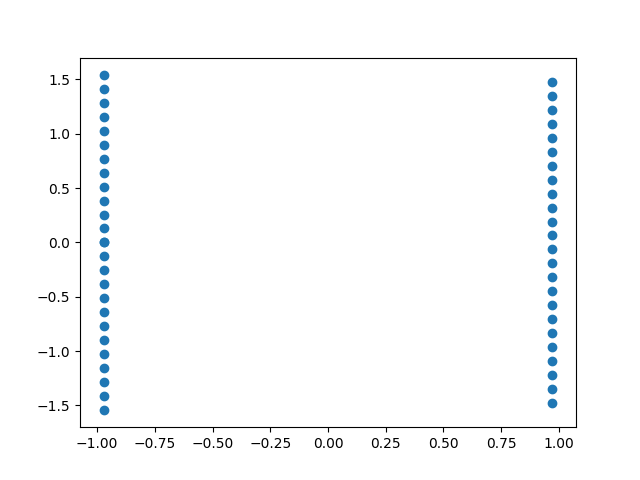

In [287]:


f = plt.figure()
ax = f.add_subplot(111)
#gamma = haversine_np_grid(sg.phi,sg.theta,0,theta_sun)
#ax.scatter(x=sg.phi,y=sg.theta,s=10,c=gamma,cmap='Blues')
theta_0 =0
phi_0  =0

x,y = gnomonic_projection(theta=np.pi/2-0.6,phi=np.linspace(-np.pi,np.pi),theta_0=theta_0,phi_0=phi_0)
theta_,phi_ = inv_gnomonic_projection(x,y,theta_0=theta_0,phi_0=phi_0)
x_,y_ = gnomonic_projection(theta=theta_,phi=phi_,theta_0=theta_0,phi_0=phi_0)

plt.scatter(theta_,phi_)
plt.show()

In [198]:
inv_gnomonic_projection(1e-18,0,theta_0=np.pi/2,phi_0=1)

(1.0, 1.0)

In [288]:
inv_gnomomic_projection(1e-5,1e-5,1,2)

(1.1415826534805447, 5.141568624135234)

<IPython.core.display.Javascript object>


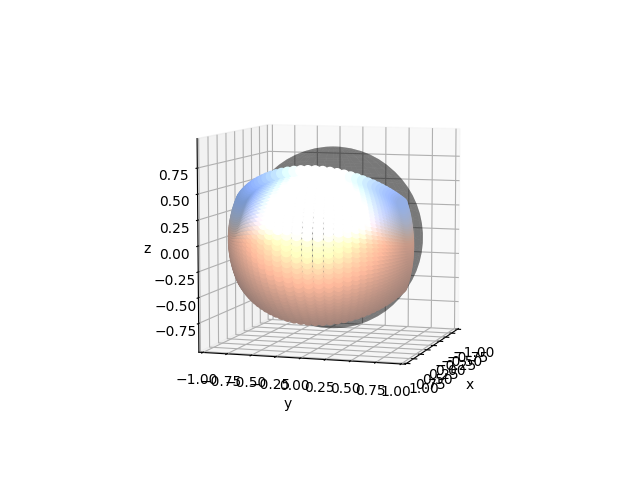

In [301]:
class SkyGrid(PolygonObject):
    def __init__(self,n,vfov,hfov,height,width,lon,lat):
        """
        n : number of point by dimension
        vfov : vertical field of view (in degree)
        hfov : horizontal field of view (in degree)
        height : screen height in pixels
        width : screen width in pixels
        lon, lat : sky position on earth 
        
        return a list of dimensionless vertices centered around (0,0)
        
        beware, if the height / width ratio is different from hfov/vfov, image will be skewed
        it should be enought to call this once at initialisation, just before vertices registration
        """
        self.n = n 
        self.hfov = hfov
        self.vfov = vfov
        self.create_raw_grid()
        # initialize altitude and azimuth for color calculation
        self.project_raw_grid(theta_0=0,phi_0=0)
        self.create_indices()
        

    def create_raw_grid(self,lower_limit = 0.8):

        self.xlim = haversine_np(0,0,0,self.hfov/180*np.pi)
        self.ylim = haversine_np(0,0,self.vfov/180*np.pi/2,0)

        self.x,self.y = np.meshgrid(np.linspace(-self.xlim, self.xlim, self.n),
                                    np.linspace(-self.ylim, self.ylim, self.n))
        
        # mask to estimate horizon median color
        self.lower_pixels_mask = self.y.ravel()<-lower_limit*self.ylim

    def create_indices(self):
        indices = []

        for i in range(self.n - 1):
            row_i   = range((i    ) * (self.n), (i + 1) * self.n)
            row_ip1 = range((i + 1) * (self.n), (i + 2) * self.n)

            indices.extend(zip(row_i, row_ip1))
            indices.extend([(row_ip1[-1], row_ip1[0])])
        
        self.indices = indices
        
    def project_raw_grid(self,theta_0,phi_0):
        """
        Project the screen raw grid on spherical coordinates centered around theta_0, phi_0
        This is used each time we change the field of view orientation
        theta and phi are like latitude and longitude on earth
        """
        self.theta_0 = theta_0
        self.phi_0 = phi_0
        
        self.theta, self.phi  = inv_gnomonic_projection(self.x.ravel(), self.y.ravel(), 
                                                       theta_0=self.theta_0, phi_0=phi_0)
        
        
        
        return self.theta, self.phi

    def get_vertices(self):
    
        X = (self.x.ravel() - self.xlim[0])/(-self.xlim-self.xlim) * self.width
        Y = (self.y.ravel() - self.ylim[0])/(-self.ylim-self.ylim) * self.height

        vertices_ = np.vstack([X,Y])
        
        
        self.vertices = vertices_.T[list(itertools.chain(*self.indices))]
        

        
        return self.vertices

    def get_colors(self,date,turbidity=2,theta_0=None,phi_0=None): 
        self.date = date
        
        if (theta_0 is not None) or (phi_0 is not None): 
            self.project_raw_grid(theta_0,phi_0)
            
        sun_theta, sun_phi = self.sun.get_direction()
        
        return self._get_colors(sun_theta=sun_theta,sun_phi=sun_phi,
                                turbidity=turbidity)
    
    def _get_colors(self,sun_theta,sun_phi,turbidity=2):

        self.colors,self.colors_xyz,lum = simulate_color(np.pi/2-self.theta, self.phi, (np.pi/2-sun_theta,sun_phi), turbidity)
        self.colors = self.colors.T
        self.median_color = colormodels.rgb_from_xyz(self.colors_xyz[self.lower_pixels_mask,:].mean(axis=0))
        #self.median_color = color_regularisaton(self.median_color)
        return self.colors[self.indices]
    
    def plot_colors(self,sun_theta,sun_phi,turbidity=2,coordinates= 'screen',**kwargs): 
        options = {'edgecolor':'none','s':20}
        options.update(kwargs)
        kwargs =  options
        self._get_colors(sun_theta=sun_theta,sun_phi=sun_phi,turbidity=turbidity)
        f = plt.figure()#figsize=[10,10])
        
        
        if coordinates == 'screen':
            ax = f.add_subplot(111)
            ax.scatter(x=self.x,y=self.y,c=self.colors,**kwargs)
        if coordinates == 'spherical':
            ax = f.add_subplot(111)
            ax.scatter(x=self.phi,y=self.theta,c=self.colors,**kwargs)
            ax.set_xlim([-np.pi,np.pi])
            ax.set_ylim([-np.pi/2,np.pi/2])
            
        if coordinates == '3D':
            r = 0.9
            pi = np.pi
            cos = np.cos
            sin = np.sin
            theta, phi = np.meshgrid(np.linspace(-np.pi/2, np.pi/2, 30),
                                     np.linspace(-np.pi, np.pi, 30))
            x = r*cos(theta)*cos(phi)
            y = r*cos(theta)*sin(phi)
            z = r*sin(theta)

            xx = np.cos(self.theta)*np.cos(self.phi)
            yy = np.cos(self.theta)*np.sin(self.phi)
            zz = np.sin(self.theta)

            #Set colours and render
            #fig = plt.figure()
            ax = f.add_subplot(111, projection='3d')

            ax.plot_surface(
                x, y, z,  rstride=1, cstride=1, color='k', alpha=0.3, linewidth=0)

            gamma = haversine_np_grid(self.phi,self.theta,sun_phi,sun_theta)

            ax.scatter(xx,yy,zz,c=self.colors,s=50,alpha=1)
            #ax.scatter(xx,yy,zz,c=gamma,s=50,alpha=1,cmap='Blues')


            ax.set_xlim([-1,1])
            ax.set_ylim([-1,1])
            ax.set_xlabel("x")
            ax.set_ylabel("y")
            ax.set_zlabel("z")
            ax.set_aspect("equal")
            return ax
        
#             ax.scatter(x=self.phi,y=self.theta,c=self.colors,**kwargs)
#             ax.set_xlim([-np.pi,np.pi])
#             ax.set_ylim([-np.pi/2,np.pi/2])
        
#         ax.invert_yaxis()
#         return ax
    
    def plot_spherical_grid(self): 
        f = plt.figure()
        ax = f.add_subplot(111)
        ax.scatter(x=self.phi,y=self.theta,s=1)
        ax.set_xlabel('phi')
        ax.set_ylabel('theta')
        #ax.set_xlim([-np.pi,np.pi])
        #ax.set_ylim([0,np.pi])
        #ax.invert_yaxis()
        return ax
    
   

        
sg = SkyGrid(n=40,vfov=120,hfov=120
             ,height=1080,width=1920,lon='5.747832',lat= '45.202847')

sg.project_raw_grid(theta_0=0,phi_0=0)
#sg.plot_spherical_grid()
#*plt.scatter(sg.x,sg.y)
#sg.plot_spherical_grid()
sg.plot_colors(sun_theta=0.5,sun_phi=0.1,turbidity =4, coordinates='3D',s=800,marker='s')
#sg.plot_3d_grid(0,0)
# check if there is not an issue with haversine distance at polar point 
#sun at zenith is broken

In [43]:
a = np.linspace(0,np.pi,100)
np.pi/2-np.abs((a-np.pi/2))
np.sign(a)*(np.pi/2 -np.abs(a-np.sign(a)*np.pi/2))
#a

array([0.        , 0.03173326, 0.06346652, 0.09519978, 0.12693304,
       0.1586663 , 0.19039955, 0.22213281, 0.25386607, 0.28559933,
       0.31733259, 0.34906585, 0.38079911, 0.41253237, 0.44426563,
       0.47599889, 0.50773215, 0.53946541, 0.57119866, 0.60293192,
       0.63466518, 0.66639844, 0.6981317 , 0.72986496, 0.76159822,
       0.79333148, 0.82506474, 0.856798  , 0.88853126, 0.92026451,
       0.95199777, 0.98373103, 1.01546429, 1.04719755, 1.07893081,
       1.11066407, 1.14239733, 1.17413059, 1.20586385, 1.23759711,
       1.26933037, 1.30106362, 1.33279688, 1.36453014, 1.3962634 ,
       1.42799666, 1.45972992, 1.49146318, 1.52319644, 1.5549297 ,
       1.5549297 , 1.52319644, 1.49146318, 1.45972992, 1.42799666,
       1.3962634 , 1.36453014, 1.33279688, 1.30106362, 1.26933037,
       1.23759711, 1.20586385, 1.17413059, 1.14239733, 1.11066407,
       1.07893081, 1.04719755, 1.01546429, 0.98373103, 0.95199777,
       0.92026451, 0.88853126, 0.856798  , 0.82506474, 0.79333

In [44]:
a = np.linspace(-np.pi,np.pi,100)
a#np.abs((np.pi/2))
np.sign(a)*(np.pi/2 -np.abs(a-np.sign(a)*np.pi/2))


array([-0.        , -0.06346652, -0.12693304, -0.19039955, -0.25386607,
       -0.31733259, -0.38079911, -0.44426563, -0.50773215, -0.57119866,
       -0.63466518, -0.6981317 , -0.76159822, -0.82506474, -0.88853126,
       -0.95199777, -1.01546429, -1.07893081, -1.14239733, -1.20586385,
       -1.26933037, -1.33279688, -1.3962634 , -1.45972992, -1.52319644,
       -1.5549297 , -1.49146318, -1.42799666, -1.36453014, -1.30106362,
       -1.23759711, -1.17413059, -1.11066407, -1.04719755, -0.98373103,
       -0.92026451, -0.856798  , -0.79333148, -0.72986496, -0.66639844,
       -0.60293192, -0.53946541, -0.47599889, -0.41253237, -0.34906585,
       -0.28559933, -0.22213281, -0.1586663 , -0.09519978, -0.03173326,
        0.03173326,  0.09519978,  0.1586663 ,  0.22213281,  0.28559933,
        0.34906585,  0.41253237,  0.47599889,  0.53946541,  0.60293192,
        0.66639844,  0.72986496,  0.79333148,  0.856798  ,  0.92026451,
        0.98373103,  1.04719755,  1.11066407,  1.17413059,  1.23

In [6]:
%matplotlib notebook

<IPython.core.display.Javascript object>


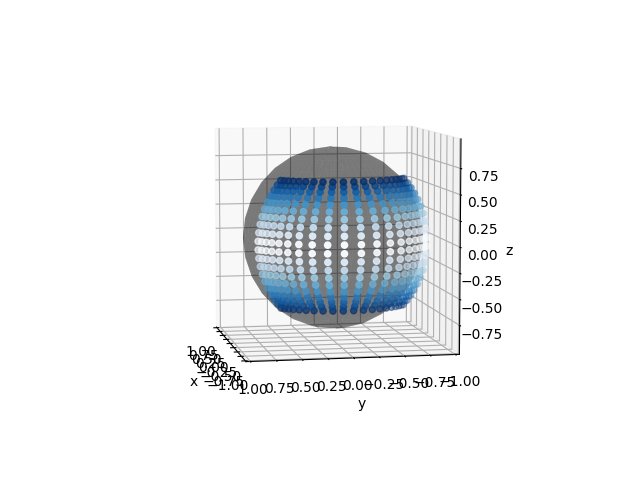

<IPython.core.display.Javascript object>


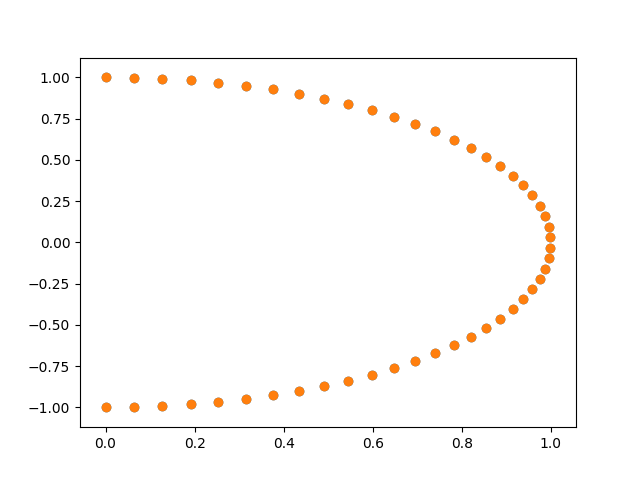

ValueError: 'c' argument has 400 elements, which is not acceptable for use with 'x' with size 400, 'y' with size 400.

In [ ]:
self.colors,self.colors_xyz,lum = simulate_color(self.theta, self.phi, (sun_theta,sun_phi), turbidity)
self.colors = self.colors.T
self.median_color = colormodels.rgb_from_xyz(self.colors_xyz[self.lower_pixels_mask,:].mean(axis=0))

In [6]:
np.max(theta

array([-0.19877574,  0.29733244, -0.41883394,  0.28375283,  0.00623428,
       -0.99909407,  0.19665125, -0.03846021,  0.78508407, -0.1737414 ,
        0.31565031,  0.20450087,  0.20975485,  0.21028067,  0.20658375,
        0.21176517,  0.21588086, -0.2232451 ,  0.26279601,  0.0759473 ,
        0.69218516,  0.28950745,  0.55348516, -0.02965681,  0.22667843,
        0.00893849,  0.22762924,  0.23150405,  0.15150449,  0.39319277,
        0.80166364,  0.13308731, -0.34747317,  0.63199478,  0.20492743,
        0.05919986,  0.11578082,  0.97872305,  0.65213466,  0.9695248 ,
        0.002825  ,  0.6099999 ,  0.9884221 ,  1.12643266,  1.34126437,
        1.25984132,  0.93570548,  1.26081383,  0.30325899,  1.19110739,
        0.37720275, -0.33959568,  1.10491621,  0.71196193,  1.03183866,
        0.33881354,  1.02861702,  0.95559335, -0.44179294,  0.93876392,
        0.60436714,  0.60339659,  0.85437888,  0.44909254,  0.18007648,
       -0.35937983,  0.01321754, -0.66091543, -0.05016729, -0.20

In [5]:
np.max([1,2])

2

In [239]:
theta_sun = np.pi/4
phi_sun = np.pi/6
theta,phi = sg.project_raw_grid(theta_0=0,phi_0=0)
gamma = haversine_np_grid(sg.phi,sg.theta,phi_sun,theta_sun)
theta_,phi_ = sg.project_raw_grid(theta_0=np.pi/6,phi_0=0.5)
gamma_ = haversine_np_grid(sg.phi,sg.theta,phi_sun,theta_sun)

a = sky_color(theta, gamma, theta_sun,turbidity=3)
a_ = sky_color(theta_, gamma_, theta_sun,turbidity=3)

/home/pascal/Project/levelscape/levelscape/sky/sky_models.py:150: RuntimeWarning: overflow encountered in exp
  Yrel   = (1+A*np.exp(B/np.cos(theta)))*(1+C*np.exp(D*gamma    )+E*(np.cos(gamma    ))**2)


In [244]:
np.exp(1e2)

2.6881171418161356e+43

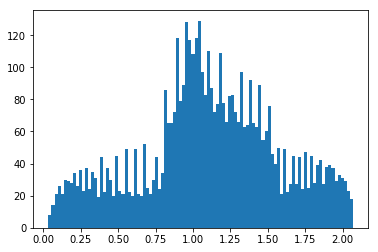

In [235]:
_ = plt.hist(gamma,bins=100)

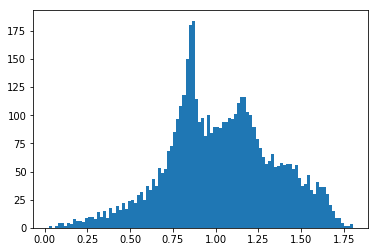

In [234]:
_ = plt.hist(gamma_,bins=100)

In [4]:
%timeit inv_gnomomic_projection(x,y,theta_0=np.pi/2,phi_0=0)

NameError: name 'x' is not defined

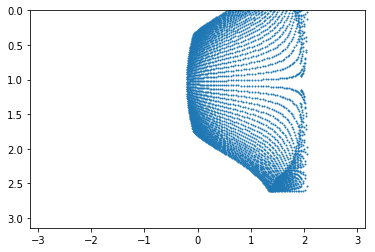

In [224]:
theta,phi = sg.project_raw_grid(theta_0=0,phi_0=0)
theta_,phi_ = sg.project_raw_grid(theta_0=np.pi/6,phi_0=0.5)
sg.plot_spherical_grid()

In [207]:
phi

array([-0.8976214 , -0.88765094, -0.87743008, ...,  0.87743008,
        0.88765094,  0.8976214 ])

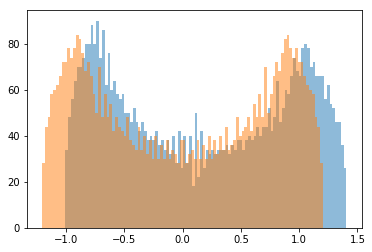

In [219]:
theta,phi = sg.project_raw_grid(theta_0=0,phi_0=0)
theta_,phi_ = sg.project_raw_grid(theta_0=np.pi/6,phi_0=0.1)
_  = plt.hist(phi_,bins=100,alpha=0.5)
_  = plt.hist(phi,bins=100,alpha=0.5)


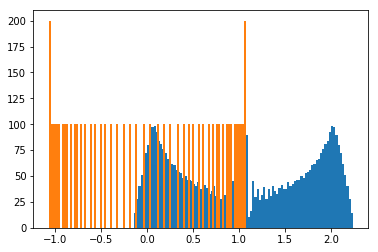

In [220]:
_  = plt.hist(theta_,bins=100)
_  = plt.hist(theta,bins=100)

In [98]:
x,y = create_raw_grid(100,210,150)       

2.6179938779914944


In [101]:
%timeit theta,phi = project_raw_grid(x,y,theta_0=np.pi/3,phi_0=0.7)

631 µs ± 194 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [85]:
np.tan(np.linspace(0,np.pi/2))

array([0.00000000e+00, 3.20680536e-02, 6.42021301e-02, 9.64687973e-02,
       1.28935722e-01, 1.61672245e-01, 1.94749983e-01, 2.28243474e-01,
       2.62230881e-01, 2.96794751e-01, 3.32022875e-01, 3.68009244e-01,
       4.04855131e-01, 4.42670336e-01, 4.81574619e-01, 5.21699359e-01,
       5.63189508e-01, 6.06205877e-01, 6.50927865e-01, 6.97556711e-01,
       7.46319396e-01, 7.97473389e-01, 8.51312412e-01, 9.08173541e-01,
       9.68445994e-01, 1.03258210e+00, 1.10111114e+00, 1.17465690e+00,
       1.25396034e+00, 1.33990890e+00, 1.43357520e+00, 1.53626854e+00,
       1.64960460e+00, 1.77560126e+00, 1.91681278e+00, 2.07652140e+00,
       2.25901742e+00, 2.47001933e+00, 2.71732305e+00, 3.01184067e+00,
       3.36933183e+00, 3.81343340e+00, 4.38128627e+00, 5.13478865e+00,
       6.18535359e+00, 7.75580253e+00, 1.03660461e+01, 1.55758072e+01,
       3.11836824e+01, 1.63312394e+16])

In [83]:
haversine_np(0,0,np.pi/4,np.pi/4)

1.0471975511965979

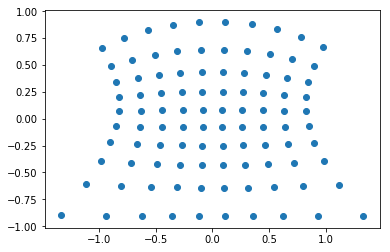

In [79]:
theta,phi,x,y = create_sky_grid_(height=1, width=1,
                          theta_min=0, theta_max=np.pi/2-0.1, phi_min=-np.pi/4,  phi_max=np.pi/4-0.01,n=10)
#plt.scatter(phi,theta)
f = plt.figure()
ax = f.add_subplot(111)
ax.scatter(x,y)
# ax.set_xlim([-4,4])
# ax.set_ylim([-4,4])

In [81]:
np.tan(np.pi/4)

0.9999999999999999

In [ ]:
create_sky_grid()

In [16]:
print(theta[-1],phi[-1])

1.6417842884851863 6.727307470636912


In [18]:
np.pi%(2*np.pi)

3.141592653589793

In [15]:
ephem.Sun()
sun = ephem.Sun()
obs = ephem.Observer()
obs.lon, obs.lat = '5.747832', '45.202847'# La Tronche
d_now =  datetime.utcnow()
d_morning =  datetime(d_now.year,d_now.month,d_now.day,7,0)
d_noon    =  datetime(d_now.year,d_now.month,d_now.day,12,0)
d_evening =  datetime(d_now.year,d_now.month,d_now.day,18,0)
d_night   =  datetime(d_now.year,d_now.month,d_now.day,2,0)

for d in [d_night,d_morning,d_noon,d_evening]:
    obs.date = d
    sun.compute(obs)
    #print('Time = {time} | Azimuth = {az:.2f} | Altitude = {alt:.2f}'.format(alt=sun.alt*180/np.pi,az=sun.az*180/np.pi,time=d.isoformat()))
    print(f'Time = {d.isoformat()} | Azimuth = {sun.az:.2f} | Altitude = {sun.alt:.2f}')

Time = 2019-04-07T02:00:00 | Azimuth = 0.72 | Altitude = -0.51
Time = 2019-04-07T07:00:00 | Azimuth = 1.74 | Altitude = 0.33
Time = 2019-04-07T12:00:00 | Azimuth = 3.29 | Altitude = 0.90
Time = 2019-04-07T18:00:00 | Azimuth = 4.86 | Altitude = 0.03


Azimuth : 
- East : 90
- South : 180
- West : 270
- North : 0

Inclination above the ground : 
- below the ground < 0
- maximum about 60° above the ground



## Function for direct and reverse camera projection 

- haversine_np : estimate the angular distance between two point on the unit sphere 
- gnomomic_projection : convert poitn in theta,phi using point theta_, phi_ as projection center. Give (x,y) 
- inv_gnomomic_projection: convert cartesian coordinates (x,y) in (theta,phi) space

In [55]:
import numpy as np 

def haversine_np(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the unit sphere  (specified in radian)

    All args must be of equal length.

    """
    lat1 = lat1
    lat2 = lat2
    #lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))

    return c
 
def inv_gnomomic_projection(x,y,theta_0,phi_0):
    rho = np.sqrt(x**2+y**2)
    c = np.arctan(rho)
    sin_c = np.sin(c)
    cos_c = np.cos(c) 
    
    phi = np.arcsin(cos_c*np.sin(phi_0)+x*sin_c*np.cos(phi_0)/rho)
    theta = theta_0 +np.arctan(y*sin_c/(rho*np.cos(phi_0)*cos_c-x*np.sin(phi_0)*sin_c))
    
    return theta,phi

def gnomomic_projection(theta,phi,theta_0,phi_0):
    """
    from http://mathworld.wolfram.com/GnomonicProjection.html
    :param theta: pi/2 - lat
    :param phi: lon
    :param theta_0:
    :param phi_0:
    :return:
    """
    c = haversine_np(phi, theta, phi_0, theta_0)
    cos_phi = np.cos(phi)
    sin_phi = np.sin(phi)
    cos_c = np.cos(c)

    sin_theta = np.sin(theta-theta_0)
    cos_theta = np.cos(theta-theta_0)

    y = cos_phi*sin_theta/cos_c
    x = (np.cos(phi_0)*sin_phi - np.sin(phi_0)*cos_phi*cos_theta)/cos_c

    return x,y

## Screen : 

-  1080 X 1600


## Camera field of view : 

- 

In [69]:
# screen height and width 
height = 1080
width = 1600

vertical_fov = np.array([50,100])/180*np.pi
horizontal_fov = np.array([-45,45])/180*np.pi

theta_0 = vertical_fov.mean()
phi_0 = horizontal_fov.mean()

y_lim = np.tan(vertical_fov-theta_0)
x_lim = np.tan(horizontal_fov-phi_0)
    
# y_lim = np.tan(vertical_fov) 
# x_lim = np.tan(horizontal_fov)

n=10

x, y = np.meshgrid(np.linspace(x_lim[0], x_lim[1], n),
                         np.linspace(y_lim[0], y_lim[1],   n))

# theta, phi = np.meshgrid(np.linspace(theta_min, theta_max, n),
#                          np.linspace(phi_min,   phi_max,   n))
# theta_0 = 0#y_lim.mean()
# phi_0 = 0#x_lim.mean()
#x,y = gnomomic_projection(theta=theta,phi=phi,phi_0 = phi_0, theta_0 = theta_0)
theta_0 = np.pi/3
phi_0 = 0
theta, phi = inv_gnomomic_projection(x,y,theta_0=theta_0, phi_0=phi_0)

x_,y_ = gnomomic_projection(theta=theta,phi= phi,theta_0=theta_0, phi_0 = phi_0)

#theta +=theta_0
#phi +=phi_0
theta *= 180/np.pi
phi *= 180/np.pi

df = pd.DataFrame(data = [theta.ravel(),phi.ravel(),x.ravel(),y.ravel(),
                          x.ravel(),y_.ravel()],index=['theta','phi','x','y','x_','y_',]).T

<IPython.core.display.Javascript object>


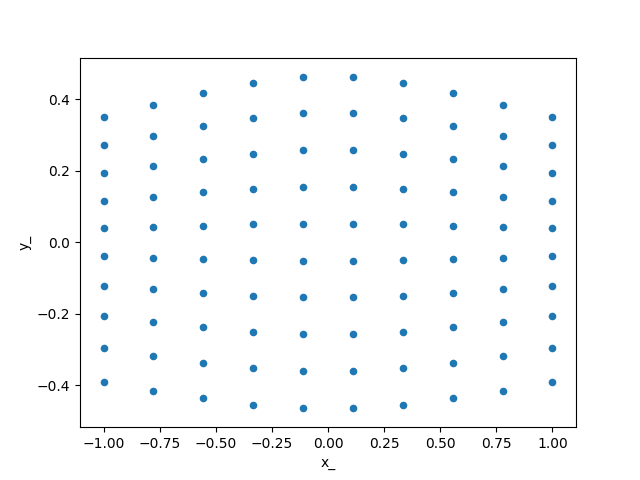

In [70]:
df.plot.scatter(x='x_',y='y_')

<IPython.core.display.Javascript object>


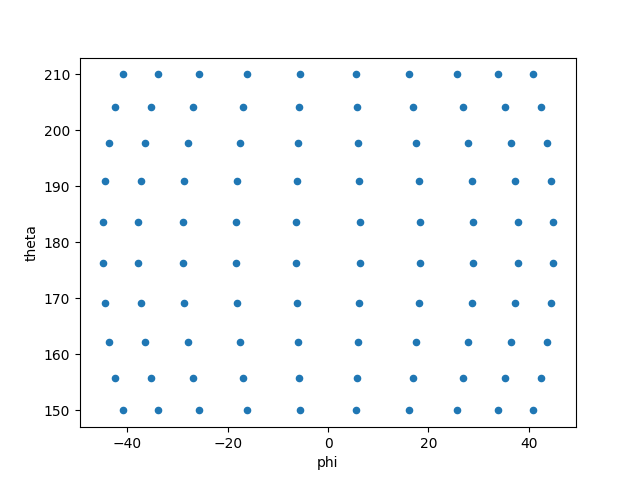

In [63]:
df.plot.scatter(x='phi',y='theta')

# Sun and color alignment

In [5]:
from levelscape.sky.sky_models import simulate_color, celestial_bodies_position
import ephem

In [21]:
from levelscape.classes import Sky

In [32]:
from levelscape.pyWorm2D.worm2d import Engine, Viewportt

In [35]:

WIN_WIDTH = 1600  # 800
WIN_HEIGHT = 1080  # 640
HALF_WIDTH = int(WIN_WIDTH / 2)
HALF_HEIGHT = int(WIN_HEIGHT / 2)

DISPLAY = (WIN_WIDTH, WIN_HEIGHT)

In [36]:
engine = Engine(DISPLAY[0], DISPLAY[1], 32, False, "levelscape")

view = Viewport(0., 0., 1, 1, DISPLAY[0], DISPLAY[1])
screen = engine.screen

In [37]:
date = datetime(2018,5,6,6,40)
sky = Sky(date=date,turbidity=2,theta_min=0.1,theta_max=(np.pi/2-0.1),phi_min=-np.pi,phi_max=np.pi-0.1)
sky.set_engine(engine=engine)


In [38]:
sun.get_direction()

AttributeError: 'Sky' object has no attribute 'screen'

In [26]:
sky.get_sun_position(date)

TypeError: get_screen_position() got an unexpected keyword argument 'date'

In [6]:
import matplotlib.pylab as plt

In [18]:
%matplotlib notebook

In [8]:
np.pi/2-sun.alt

1.5430627624180655

In [15]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets



<IPython.core.display.Javascript object>


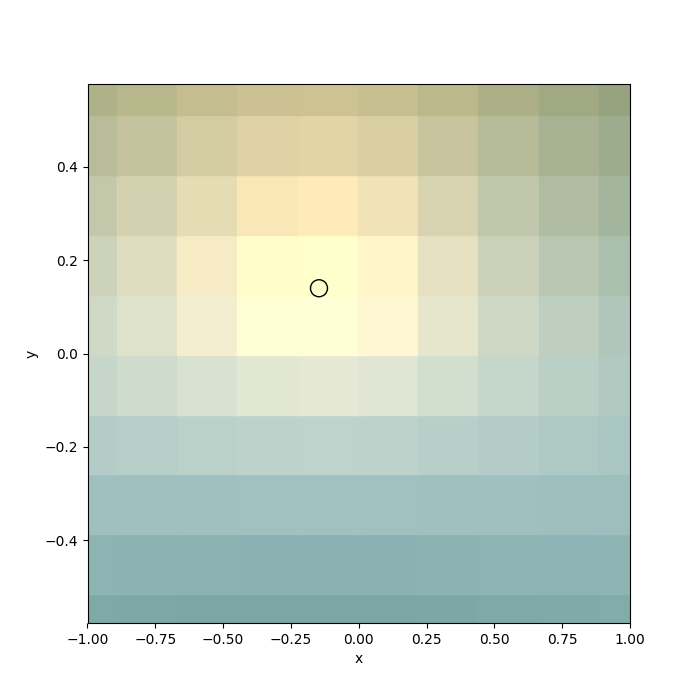

interactive(children=(IntSlider(value=0, description='i', max=719), FloatSlider(value=12.0, description='turbi…

<function __main__.plot_sky(i, turbidity)>

In [20]:
obs = ephem.Observer()
#%%timeit 
dates = pd.date_range(start=datetime(2018,8,3,4,30),periods=60*12,freq='1min')
obs = ephem.Observer()
obs.lon, obs.lat = '5.747832', '45.202847'
sun = ephem.Sun()

f =  plt.figure(figsize=[7,7])
#ax = f.add_subplot(111)
#
def plot_sky(i,turbidity): 

 
    ax = f.add_subplot(111)
    obs.date = dates[i]
    sun.compute(obs)
         
    sun_theta_phi = [np.pi/2-sun.alt,np.pi+sun.az]
    sun_x,sun_y = gnomomic_projection(theta=sun_theta_phi[0]-theta_0,phi= sun_theta_phi[1]-phi_0,theta_0=0, phi_0 = 0)
    colors, colors_xyz, lum = simulate_color(df['theta']/180*np.pi,df['phi']/180*np.pi,sun_theta_phi=sun_theta_phi,turbidity=turbidity)
    df.plot.scatter(x='x',y='y',c=colors.T,s=2000,marker='s',ax=ax)
    ax.scatter([sun_x],[sun_y],s=[150],marker='o', facecolors='none', edgecolors='k')
    ax.set_xlim(x_lim)
    ax.set_ylim(y_lim)
    
    plt.show()
    #ax.remove()
    
interact(plot_sky, i = widgets.IntSlider(value=0,
                                               min=0,
                                               max=60*12-1,
                                               step=1),
        turbidity=widgets.FloatSlider(value=12,min=1,max=20,step=0.2))
# plot_sky(10,turbidity=12)
    

In [75]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

interactive(children=(IntSlider(value=1, description='i', max=99, min=1), FloatSlider(value=12.0, description=…

<function __main__.plot_sky(i, turbidity)>

In [18]:
# theta_min = -15/180*np.pi
# theta_max = -45/180*np.pi
# phi_min = -45/180*np.pi
# phi_max = 45/180*np.pi
        
# n= 20

# theta, phi = np.meshgrid(np.linspace(theta_min, theta_max, n),
#                          np.linspace(phi_min,   phi_max,   n))
# theta_0 = 0.1
# phi_0 = 0.
# x,y = gnomomic_projection(theta=theta,phi=phi,phi_0 = phi_0, theta_0 = theta_0)
# theta_, phi_ = inv_gnomomic_projection(x,y,theta_0=theta_0, phi_0=phi_0)

# df = pd.DataFrame(data = [theta.ravel(),phi.ravel(),x.ravel(),y.ravel(),
#                           theta_.ravel(),phi_.ravel()],index=['theta','phi','x','y','theta_','phi_',]).T

In [134]:
#%timeit theta_, phi_ = inv_gnomomic_projection(x,y,theta_0=theta_0, phi_0=phi_0)


In [19]:
#df.plot.scatter(x='phi',y='theta',figsize=[12,12])

In [20]:
#df.plot.scatter(x='x',y='y',figsize=[12,12])

In [21]:
#df.plot.scatter(x='phi_',y='theta_',figsize=[12,12])

In [23]:
y_lim

array([-0.57735027,  0.57735027])

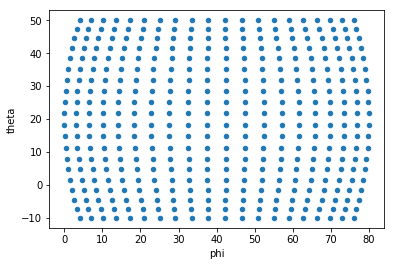

In [24]:
df.plot.scatter(x='phi',y='theta')

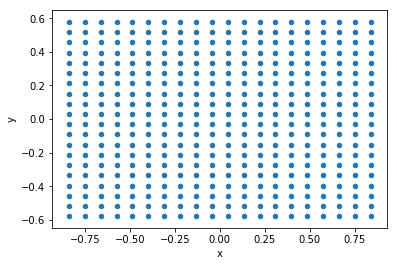

In [25]:
df.plot.scatter(x='x',y='y')

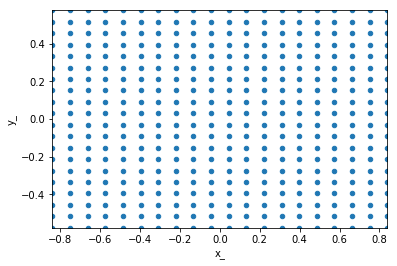

In [26]:
df.plot.scatter(x='x_',y='y_',xlim=x_lim,ylim=y_lim)

In [42]:
%matplotlib inline

In [40]:
z.shape

(100, 100)

In [38]:
list(zip(z,z,z))[0]

(array([ 10.        ,   9.99496542,   9.97986676,   9.95471923,
          9.91954813,   9.87438889,   9.81928697,   9.75429787,
          9.67948701,   9.59492974,   9.50071118,   9.39692621,
          9.28367933,   9.16108457,   9.02926538,   8.88835449,
          8.73849377,   8.57983413,   8.41253533,   8.23676581,
          8.05270258,   7.86053095,   7.66044443,   7.4526445 ,
          7.23734038,   7.01474888,   6.78509412,   6.54860734,
          6.30552667,   6.05609687,   5.8005691 ,   5.53920064,
          5.27225468,   5.        ,   4.72271075,   4.44066613,
          4.15415013,   3.86345126,   3.56886222,   3.27067963,
          2.96920375,   2.66473814,   2.35758936,   2.04806668,
          1.73648178,   1.42314838,   1.108382  ,   0.79249957,
          0.47581916,   0.15865964,  -0.15865964,  -0.47581916,
         -0.79249957,  -1.108382  ,  -1.42314838,  -1.73648178,
         -2.04806668,  -2.35758936,  -2.66473814,  -2.96920375,
         -3.27067963,  -3.56886222,  -3.

In [143]:
from ephem import stars
import matplotlib.pylab as plt

In [144]:
%matplotlib inline

## Performance : 

50 fps time budget : 20 ms

- calculating the position of the 94 stars once : 0.7 ms
- collecting those position and converting them to scrren coordinates : 0.13 ms

In [145]:
1 / 50

0.02

In [146]:
from collections import defaultdict


In [147]:
#%%timeit 
dates = pd.date_range(start=datetime.utcnow(),periods=1,freq='1min')

obs = ephem.Observer()
obs.lon, obs.lat = '5.747832', '45.202847'

sun = ephem.Sun()

# obs.date = datetime.utcnow()
# sun.compute(obs)
# sun.alt
res = defaultdict(list)
for date in dates : 
    obs.date = date 
    for star_name,star in stars.stars.items(): 
        star.compute(obs)
        
        res[star_name].append((star.alt,star.az))
    sun.compute(obs)
    res['sun'].append((sun.alt,sun.az))

In [148]:
%%timeit
theta,phi = zip(*[pos[0] for star_name, pos in res.items()])
x,y = gnomomic_projection(theta=np.array(theta),phi=np.array(phi),theta_0=0,phi_0 = np.pi)

135 µs ± 832 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


(0, 1.2)

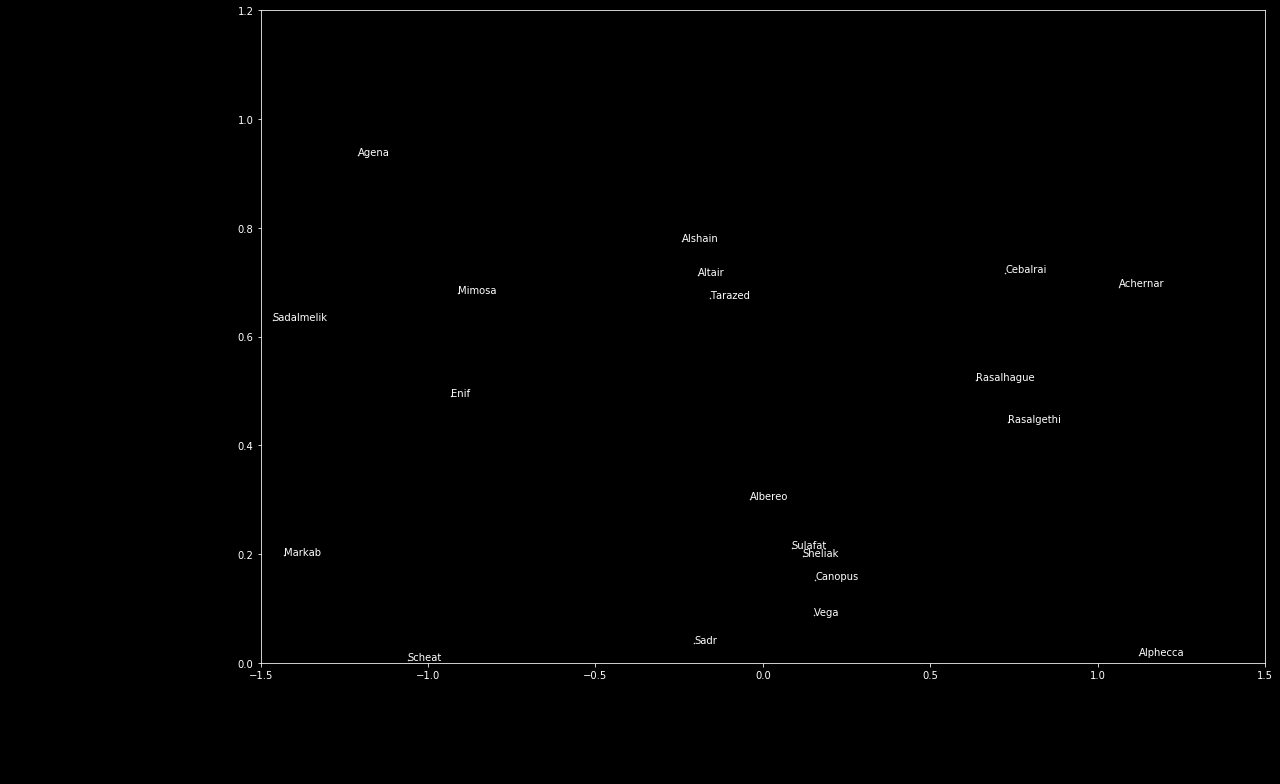

In [149]:
plt.style.use('dark_background')
f,ax = plt.subplots(1,1,figsize = [18,12,])
for star_name in res.keys():#stars.stars.items(): 
    #if star.dec > 0 :
    if True :
        
        theta,phi = np.array(res[star_name]).T
        x,y = gnomomic_projection(theta=theta,phi=phi,theta_0=0,phi_0 = np.pi)
        ax.plot(x,y,'w.',markersize=1)
        ax.set_xlim([-1,1])
        ax.set_ylim([0,1.2])
        ax.annotate(star_name, xy=(x[-1],y[-1]))
theta,phi= np.array(res['sun']).T
x,y = gnomomic_projection(theta=theta,phi=phi,theta_0=0,phi_0 = np.pi)
ax.plot(x,y,'r')
ax.set_xlim([-1.5,1.5])
ax.set_ylim([0,1.2])
        #ax.text(x[0],y[0],star_name)

(0, 1.2)

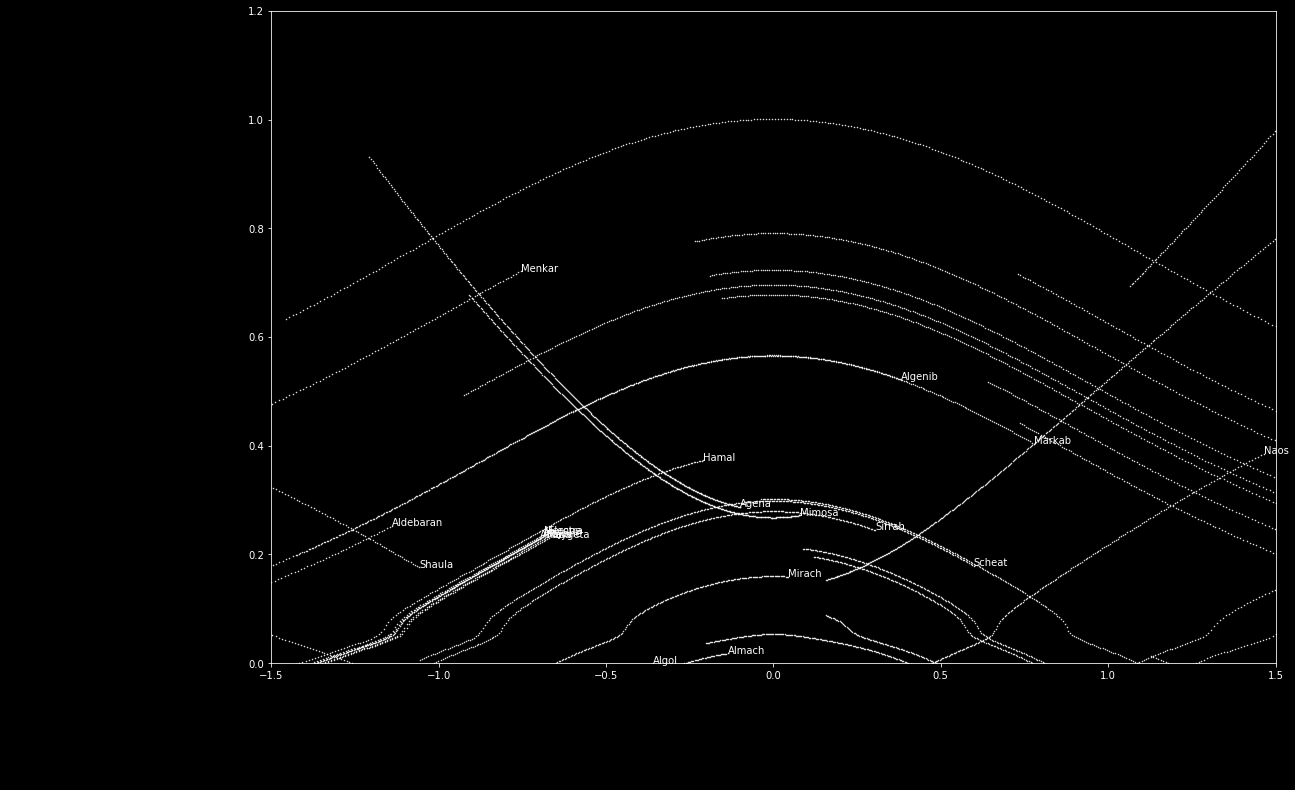

In [151]:
dates = pd.date_range(start=datetime.utcnow(),periods=60*6,freq='1min')

obs = ephem.Observer()
obs.lon, obs.lat = '5.747832', '45.202847'

sun = ephem.Sun()

# obs.date = datetime.utcnow()
# sun.compute(obs)
# sun.alt
from collections import defaultdict
res = defaultdict(list)
for date in dates : 
    obs.date = date 
    for star_name,star in stars.stars.items(): 
        star.compute(obs)
        
        res[star_name].append((star.alt,star.az))
    sun.compute(obs)
    res['sun'].append((sun.alt,sun.az))
plt.style.use('dark_background')
f,ax = plt.subplots(1,1,figsize = [18,12,])
for star_name in res.keys():#stars.stars.items(): 
    #if star.dec > 0 :
    if True :
        
        theta,phi = np.array(res[star_name]).T
        x,y = gnomomic_projection(theta=theta,phi=phi,theta_0=0,phi_0 = np.pi)
        ax.plot(x,y,'w.',markersize=1)
        ax.set_xlim([-1,1])
        ax.set_ylim([0,1.2])
        ax.annotate(star_name, xy=(x[-1],y[-1]))
theta,phi= np.array(res['sun']).T
x,y = gnomomic_projection(theta=theta,phi=phi,theta_0=0,phi_0 = np.pi)
ax.plot(x,y,'r')
ax.set_xlim([-1.5,1.5])
ax.set_ylim([0,1.2])
        #ax.text(x[0],y[0],star_name)
    #res[star_name] = np.vstack([x,y]).T 

# Sky alignement

## grid vertices

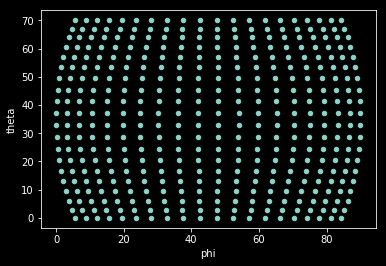

In [171]:
# screen height and width 
height = 1080
width = 1600

vertical_fov = np.array([0,70])/180*np.pi
horizontal_fov = np.array([0,90])/180*np.pi

theta_0 = vertical_fov.mean()
phi_0 = horizontal_fov.mean()

y_lim = np.tan(vertical_fov-theta_0)
x_lim = np.tan(horizontal_fov-phi_0)
    
# y_lim = np.tan(vertical_fov) 
# x_lim = np.tan(horizontal_fov)


x, y = np.meshgrid(np.linspace(x_lim[0], x_lim[1], n),
                         np.linspace(y_lim[0], y_lim[1],   n))

# theta, phi = np.meshgrid(np.linspace(theta_min, theta_max, n),
#                          np.linspace(phi_min,   phi_max,   n))
# theta_0 = 0#y_lim.mean()
# phi_0 = 0#x_lim.mean()
#x,y = gnomomic_projection(theta=theta,phi=phi,phi_0 = phi_0, theta_0 = theta_0)
theta, phi = inv_gnomomic_projection(x,y,theta_0=0, phi_0=0)

x_,y_ = gnomomic_projection(theta=theta,phi= phi,theta_0=0, phi_0 = 0)

theta +=theta_0
phi +=phi_0
theta *= 180/np.pi
phi *= 180/np.pi

df = pd.DataFrame(data = [theta.ravel(),phi.ravel(),x.ravel(),y.ravel(),
                          x.ravel(),y_.ravel()],index=['theta','phi','x','y','x_','y_',]).T

df.plot.scatter(x='phi',y='theta')#,xlim=x_lim,ylim=y_lim)

## Bodies positions

In [ ]:
stars.stars['Megrez']

(-2.800830152838839, 2.800830152838839)

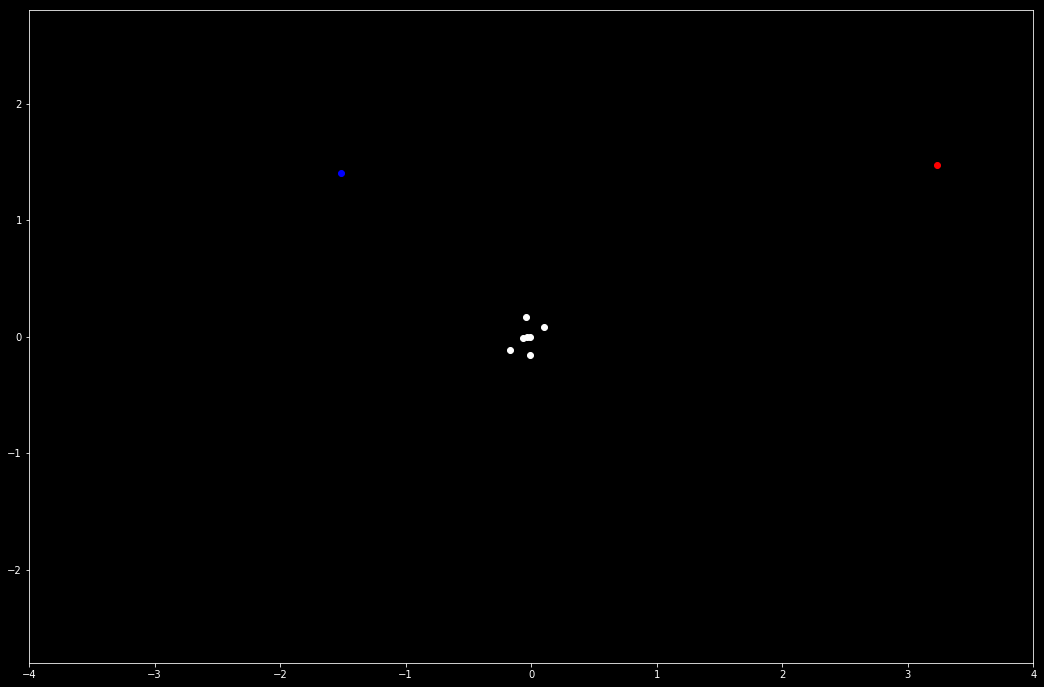

In [173]:
orion = ['Saiph','Bellatrix', 'Mintaka','Alnilam', 'Alnitak', 'Rigel', 'Betelgeuse']

dates = pd.date_range(start=datetime.utcnow(),periods=1,freq='1min')

obs = ephem.Observer()
obs.lon, obs.lat = '5.747832', '45.202847'

sun = ephem.Sun()
moon = ephem.Moon()


# obs.date = datetime.utcnow()
# sun.compute(obs)
# sun.alt
res = defaultdict(list)
for date in dates : 
    obs.date = date 
    for star_name in orion :
        star = stars.stars[star_name]
        star.compute(obs)
        
        res[star_name].append((star.alt-theta_0,star.az-phi_0+np.pi))
        
        
    sun.compute(obs)
    moon.compute(obs)
    res['moon'].append((moon.alt, moon.az+np.pi))
    res['sun'].append((sun.alt,sun.az+np.pi))

    
theta,phi = zip(*[pos[0] for star_name, pos in res.items()])
x,y = gnomomic_projection(theta=np.array(theta),phi=np.array(phi),theta_0=0,phi_0 = 0)
X = (x.ravel() - x_lim[0])/(x_lim[1]-x_lim[0])  * width
Y = (y.ravel() - y_lim[0])/ (y_lim[1]-y_lim[0]) * height

f,ax = plt.subplots(1,1,figsize = [18,12,])
ax.scatter(x[:-2],y[:-2],c='w')
ax.scatter(x[-2],y[-2],c='b')
ax.scatter(x[-1],y[-1],c='r')

ax.set_xlim(x_lim*4)
ax.set_ylim(y_lim*4)

In [168]:
np.array(res['sun'])*180/np.pi

array([[ 56.14455454, 420.66870952]])

In [163]:
ephem.__file__


'/home/pascal/anaconda/envs/py36/lib/python3.6/site-packages/ephem/__init__.py'

In [110]:
sun.az

3.91606068611145

(-0.5773502691896257, 0.5773502691896258)

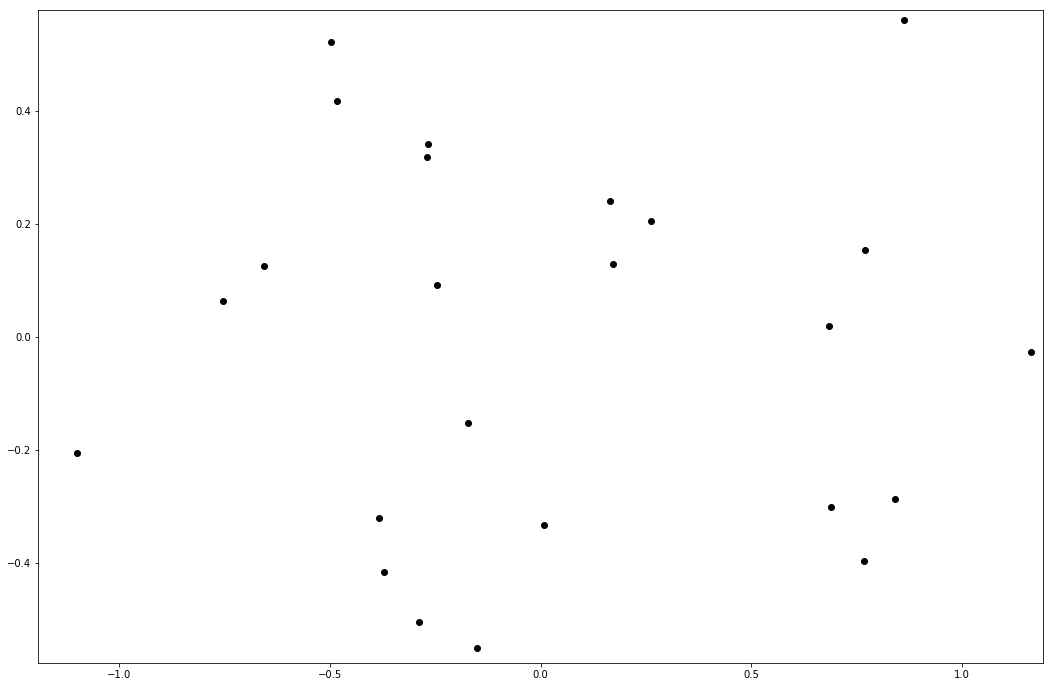

In [100]:
from blobformer.sky_models import simulate_color

In [ ]:
simulate_color(theta,phi,sun_theta_phi,turbidity)

In [ ]:
dates = pd.date_range(start=datetime.utcnow(),periods=2,freq='1min')

obs = ephem.Observer()
obs.lon, obs.lat = '5.7166700', '45.1666700'

sun = ephem.Sun()

# obs.date = datetime.utcnow()
# sun.compute(obs)
# sun.alt
from collections import defaultdict
res = defaultdict(list)
for date in dates : 
    obs.date = date 
    sun.compute(obs)
        
    res['sun'].append((sun.alt,sun.az,sun.mag))
plt.style.use('dark_background')
f,ax = plt.subplots(1,1,figsize = [18,12,])


#if True :

theta,phi,mag = np.array(res['sun']).T
x,y = gnomomic_projection(theta=theta,phi=phi,theta_0=0,phi_0 = np.pi)
ax.scatter(x,y,c=mag)
ax.set_xlim([-1.5,1.5])
ax.set_ylim([0,1.2])


In [ ]:
obs.date = datetime.utcnow()
sun.compute(obs)
sun.alt

In [ ]:
mag.std()

In [ ]:
{star_name:star.dec for star_name,star in stars.stars.items()}

In [ ]:
a.dec

In [ ]:
import matplotlib.pylab as plt 

In [ ]:
plt.scatter(res['Altair'])

In [ ]:
theta,phi = np.array(res['Altair']).T
theta

In [ ]:
df_star = pd.DataFrame(res)

In [ ]:
df_star

In [ ]:
dates